In [1]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

from fastai.vision import *
from fastai.metrics import error_rate
import torch

torch.cuda.empty_cache()

In [2]:
#masukkin image dataset nya disini, tapi per folder harus ada labelnya
#Reference Implementation fastai --->>> https://gilberttanner.com/blog/fastai-image-classification

tfms = get_transforms(flip_vert=False, max_rotate=10,max_zoom=1.05,
                      max_warp=0)
defaults.device = torch.device("cuda")
data = ImageDataBunch.from_folder(Path('.'),
                                  train = 'train/',
                                  test = 'test/',
                                  valid_pct = 0.2,
                                  ds_tfms = get_transforms(),
                                  size = 128,
                                  bs = 32,
                                  num_workers = 50
                                  ).normalize(imagenet_stats)

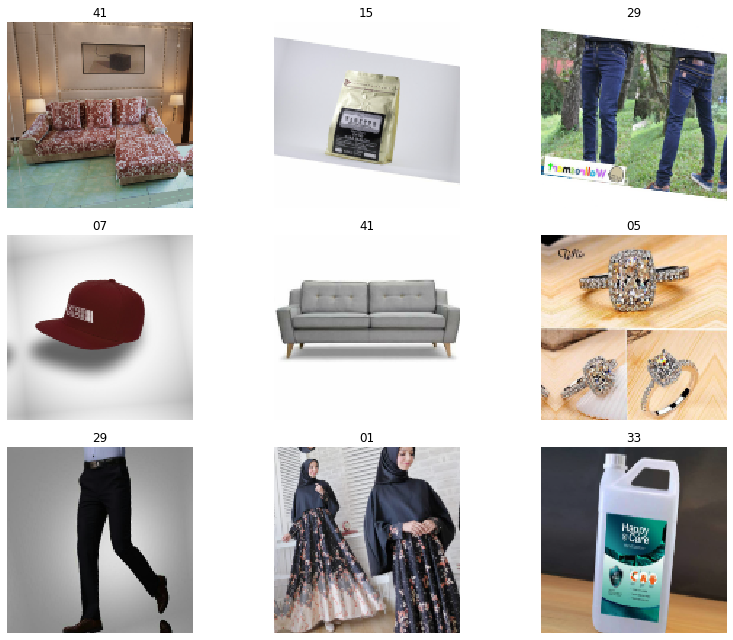

In [3]:
data.show_batch(rows=3, figsize=(12,9))

In [4]:
len(data.classes), data.c

(42, 42)

In [8]:
# ganti loss ke focal loss
import pretrainedmodels
from torch import nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=1., gamma=2.):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets, **kwargs):
        CE_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-CE_loss)
        F_loss = self.alpha * ((1-pt)**self.gamma) * CE_loss
        return F_loss.mean()
    
# model nyta buat cnn_learner
def resnext50_32x4d(pretrained=False):
    pretrained = 'imagenet' if pretrained else None
    model = bn.se_resnext50_32x4d(pretrained=pretrained)
    return nn.Sequential(*list(model.children()))

In [9]:
# model fastai --->>> https://docs.fast.ai/vision.models.html
# best practice: start small, 
# baru ganti model IF tuning hyperparameter udah gak improved.
learn = cnn_learner(data, 
                    resnext50_32x4d, 
                    pretrained=True, 
                    cut=-2, 
                    metrics = [accuracy]
                   )
learn.loss_fn = FocalLoss()


Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/se_resnext50_32x4d-a260b3a4.pth" to /root/.cache/torch/checkpoints/se_resnext50_32x4d-a260b3a4.pth


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.63E-03
Min loss divided by 10: 3.31E-03


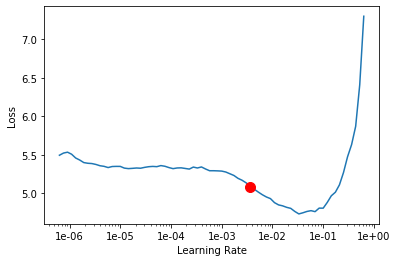

In [10]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(32, max_lr=slice(2e-2), wd=1e-5)

epoch,train_loss,valid_loss,accuracy,time
0,1.888170,1.517232,0.584828,09:29
1,1.650472,1.410657,0.613863,09:32
2,1.548776,1.288476,0.644084,09:53
3,1.533877,1.235545,0.658981,09:38
4,1.548831,1.245044,0.656134,09:35
5,1.606628,1.238666,0.669466,09:35


In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

In [ ]:
learn.save('resnext50_32x4d_1');
learn.unfreeze();
learn = learn.clip_grad();

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.load('resnext50_32x4d_1');
learn.unfreeze();
learn = learn.clip_grad();

In [ ]:
lr = [3e-3/100, 3e-3/20, 3e-3/10]
learn.fit_one_cycle(36, lr, wd=1e-7)

In [ ]:
learn.save('resnext50_32x4d_2');